In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/mhskjelvareid/dagm-2007-competition-dataset-optical-inspection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mehulrathoreme22b155
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mhskjelvareid/dagm-2007-competition-dataset-optical-inspection


100%|██████████| 5.49G/5.49G [01:46<00:00, 55.5MB/s]


In [ ]:
!mkdir -p dataset/train/ok
!mkdir -p dataset/train/defect

In [ ]:
!find dataset -type d

dataset
dataset/train
dataset/train/defect
dataset/train/ok


In [ ]:
!mkdir -p dataset/test/ok
!mkdir -p dataset/test/defect

In [ ]:
source = "/content/dagm-2007-competition-dataset-optical-inspection/DAGM_KaggleUpload/Class1"

In [ ]:
import os, shutil

In [ ]:
ok_dir = "/content/dataset/train/ok"

In [ ]:
defect_dir = "/content/dataset/train/defect"

DATA PREPROCESSING


In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
import random

# -----------------------------
# CONFIG
# -----------------------------
PATCH_SIZE = 224
PAD_RATIO = 1.0          # strong context
JITTER_RATIO = 0.15      # randomness to prevent memorization

# -----------------------------
# UTILITIES
# -----------------------------
def get_defect_bbox(label_path, threshold=200):
    label = Image.open(label_path).convert("L")
    mask = np.array(label) > threshold

    coords = np.column_stack(np.where(mask))
    if len(coords) == 0:
        return None

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    return x_min, y_min, x_max, y_max


def add_padding_and_jitter(bbox, img_w, img_h):
    x1, y1, x2, y2 = bbox
    w = x2 - x1
    h = y2 - y1

    pad_w = int(w * PAD_RATIO)
    pad_h = int(h * PAD_RATIO)

    x1 -= pad_w
    y1 -= pad_h
    x2 += pad_w
    y2 += pad_h

    # jitter
    jw = int(JITTER_RATIO * (x2 - x1))
    jh = int(JITTER_RATIO * (y2 - y1))

    x1 += random.randint(-jw, jw)
    y1 += random.randint(-jh, jh)
    x2 += random.randint(-jw, jw)
    y2 += random.randint(-jh, jh)

    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_w, x2)
    y2 = min(img_h, y2)

    return x1, y1, x2, y2


def random_ok_crop(img, crop_w, crop_h):
    if img.width < crop_w or img.height < crop_h:
        return None

    x = random.randint(0, img.width - crop_w)
    y = random.randint(0, img.height - crop_h)

    return img.crop((x, y, x + crop_w, y + crop_h))


# -----------------------------
# MAIN PIPELINE
# -----------------------------
def copy_split(class_dir, split, target_root):
    split_dir = os.path.join(class_dir, split)
    if not os.path.exists(split_dir):
        return 0, 0

    target_split = "train" if split.lower() == "train" else "test"

    ok_dir = os.path.join(target_root, target_split, "ok")
    defect_dir = os.path.join(target_root, target_split, "defect")

    os.makedirs(ok_dir, exist_ok=True)
    os.makedirs(defect_dir, exist_ok=True)

    label_dir = os.path.join(split_dir, "Label")

    defect_labels = {}
    if os.path.exists(label_dir):
        for f in os.listdir(label_dir):
            if f.endswith("_label.PNG"):
                img_name = f.replace("_label.PNG", ".PNG")
                defect_labels[img_name] = os.path.join(label_dir, f)

    ok_count = 0
    defect_count = 0

    for f in os.listdir(split_dir):
        if not f.endswith(".PNG"):
            continue

        img_path = os.path.join(split_dir, f)
        raw_img = Image.open(img_path).convert("RGB")

        # ---------------- DEFECT ----------------
        if f in defect_labels:
            bbox = get_defect_bbox(defect_labels[f])
            if bbox is None:
                continue

            x1, y1, x2, y2 = add_padding_and_jitter(
                bbox, raw_img.width, raw_img.height
            )

            crop = raw_img.crop((x1, y1, x2, y2))
            crop = crop.resize((PATCH_SIZE, PATCH_SIZE))


            save_name = f"{os.path.basename(class_dir)}_{split}_defect_{defect_count}.png"
            crop.save(os.path.join(defect_dir, save_name))

            defect_count += 1

        # ---------------- OK ----------------
        else:
            # match defect crop scale
            crop_w = int(PATCH_SIZE * random.uniform(0.8, 1.2))
            crop_h = crop_w

            ok_crop = random_ok_crop(raw_img, crop_w, crop_h)
            if ok_crop is None:
                continue

            ok_crop = ok_crop.resize((PATCH_SIZE, PATCH_SIZE))
            save_name = f"{os.path.basename(class_dir)}_{split}_ok_{ok_count}.png"
            ok_crop.save(os.path.join(ok_dir, save_name))

            ok_count += 1

    return ok_count, defect_count


# -----------------------------
# DRIVER (UNCHANGED STRUCTURE)
# -----------------------------
BASE = "/content/dagm-2007-competition-dataset-optical-inspection/DAGM_KaggleUpload"
TARGET = "/content/dataset"

total_ok = 0
total_defect = 0

for cls in sorted(os.listdir(BASE)):
    class_dir = os.path.join(BASE, cls)
    if not os.path.isdir(class_dir):
        continue

    for split in ["Train", "Test"]:
        ok, defect = copy_split(class_dir, split, TARGET)
        total_ok += ok
        total_defect += defect

print("TOTAL OK:", total_ok)
print("TOTAL DEFECT:", total_defect)


TOTAL OK: 14000
TOTAL DEFECT: 2100


In [ ]:
import random

# pick 10 random samples from train and val
train_samples = random.sample(os.listdir("dataset/train/defect"), 5)
val_samples = random.sample(os.listdir("dataset/test/defect"), 5)

print("TRAIN DEFECT SAMPLES:", train_samples)
print("VAL DEFECT SAMPLES:", val_samples)


TRAIN DEFECT SAMPLES: ['Class7_Train_defect_75.png', 'Class3_Train_defect_55.png', 'Class10_Train_defect_148.png', 'Class3_Train_defect_20.png', 'Class1_Train_defect_68.png']
VAL DEFECT SAMPLES: ['Class7_Test_defect_126.png', 'Class8_Test_defect_58.png', 'Class5_Test_defect_6.png', 'Class8_Test_defect_101.png', 'Class10_Test_defect_73.png']


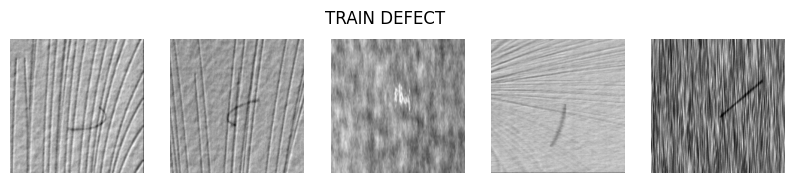

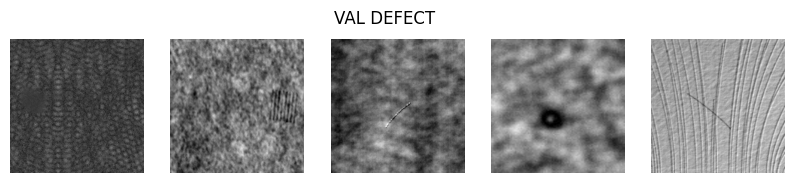

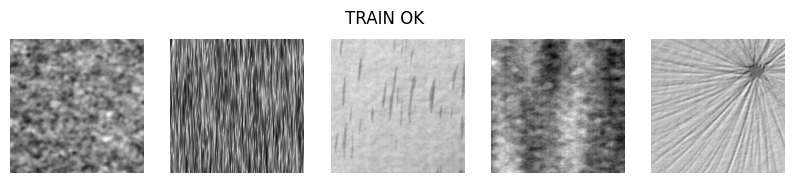

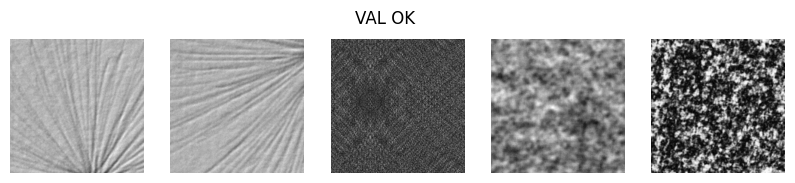

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(folder, n=5, title=""):
    imgs = os.listdir(folder)[:n]
    plt.figure(figsize=(10,2))
    for i, f in enumerate(imgs):
        img = Image.open(os.path.join(folder, f))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples("dataset/train/defect", title="TRAIN DEFECT")
show_samples("dataset/test/defect", title="VAL DEFECT")

show_samples("dataset/train/ok", title="TRAIN OK")
show_samples("dataset/test/ok", title="VAL OK")


OLD PREPROCESSING

In [ ]:
def copy_split(class_dir,split,target_root):
    split_dir = os.path.join(class_dir, split)
    if not os.path.exists(split_dir):
        return 0, 0
    target_split = "train" if split.lower() == "train" else "test"

    ok_dir = os.path.join(target_root, target_split, "ok")
    defect_dir = os.path.join(target_root, target_split, "defect")

    os.makedirs(ok_dir, exist_ok=True)
    os.makedirs(defect_dir, exist_ok=True)


    label_dir = os.path.join(split_dir, "Label")
    defect_imgs = set()


    if os.path.exists(label_dir):
        for f in os.listdir(label_dir):
            if f.endswith("_label.PNG"):
                defect_imgs.add(f.replace("_label.PNG", ".PNG"))


    ok_count = 0
    defect_count = 0

    for f in os.listdir(split_dir):
        if not f.lower().endswith(".png"):
            continue

        src = os.path.join(split_dir, f)

        if f in defect_imgs:
            shutil.copy(src, os.path.join(defect_dir, f))
            defect_count += 1
        else:
            shutil.copy(src, os.path.join(ok_dir, f))
            ok_count += 1

    return ok_count, defect_count












#########################################

    # Collect defective image names
'''  defect_imgs = set()
    if os.path.exists(label_dir):
        for f in os.listdir(label_dir):
            if f.endswith("_label.PNG"):
                defect_imgs.add(f.replace("_label.PNG", ".PNG"))

    ok_count, defect_count = 0, 0

    for f in os.listdir(split_dir):
        if not f.lower().endswith(".png"):
            continue

        src = os.path.join(split_dir, f)

        if f in defect_imgs:
            shutil.copy(src, os.path.join(defect_dir, f))
            defect_count += 1
        else:
            shutil.copy(src, os.path.join(ok_dir, f))
            ok_count += 1

    return ok_count, defect_count'''

'  defect_imgs = set()\n    if os.path.exists(label_dir):\n        for f in os.listdir(label_dir):\n            if f.endswith("_label.PNG"):\n                defect_imgs.add(f.replace("_label.PNG", ".PNG"))\n\n    ok_count, defect_count = 0, 0\n\n    for f in os.listdir(split_dir):\n        if not f.lower().endswith(".png"):\n            continue\n\n        src = os.path.join(split_dir, f)\n\n        if f in defect_imgs:\n            shutil.copy(src, os.path.join(defect_dir, f))\n            defect_count += 1\n        else:\n            shutil.copy(src, os.path.join(ok_dir, f))\n            ok_count += 1\n\n    return ok_count, defect_count'

In [ ]:
BASE = "/content/dagm-2007-competition-dataset-optical-inspection/DAGM_KaggleUpload"
TARGET = "/content/dataset"

total_ok = total_defect = 0

for cls in sorted(os.listdir(BASE)):
    class_dir = os.path.join(BASE, cls)
    if not os.path.isdir(class_dir):
        continue

    for split in ["Train", "Test"]:
        ok, defect = copy_split(class_dir, split, TARGET)
        total_ok += ok
        total_defect += defect

print("TOTAL OK:", total_ok)
print("TOTAL DEFECT:", total_defect)

TOTAL OK: 14000
TOTAL DEFECT: 2100


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Model Implementation

In [ ]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(
    root="dataset/train",
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root="dataset/test",
    transform=val_transform
)

print(train_dataset.classes)

['defect', 'ok']


Creating batches for GPU

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

Model

In [ ]:
import torch.nn as nn
from torchvision import models

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Setup

In [ ]:
import torch.optim as optim
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


num_ok = 14000
num_defect = 2100

total = num_ok + num_defect
w_defect =   (total / (2 * num_defect))
w_ok = total / (2 * num_ok)
#w_defect = total / (2 * num_defect)

class_weights = torch.tensor([w_ok, w_defect], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)


#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Training Loop

In [ ]:
num_epochs = 4
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "paint_defect_cnn.pth")


Epoch 1/4 | Train Acc: 0.964 | Val Acc: 0.989
Epoch 2/4 | Train Acc: 0.992 | Val Acc: 0.998
Epoch 3/4 | Train Acc: 0.992 | Val Acc: 0.997
Epoch 4/4 | Train Acc: 0.998 | Val Acc: 0.997


Other Matrices

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    target_names=val_dataset.classes
))


Confusion Matrix:
 [[1031   23]
 [   0 6996]]

Classification Report:

              precision    recall  f1-score   support

      defect       1.00      0.98      0.99      1054
          ok       1.00      1.00      1.00      6996

    accuracy                           1.00      8050
   macro avg       1.00      0.99      0.99      8050
weighted avg       1.00      1.00      1.00      8050



In [ ]:
import torch

torch.save(model.state_dict(), "model.pth")

In [ ]:
torch.save(model.state_dict(), "paint_defect_resnet18.pth")

In [ ]:
!ls

In [ ]:
from google.colab import files
files.download("model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Inference

Using device: cuda
Model loaded successfully
{'prediction': 'DEFECT', 'confidence': 1.0, 'raw_probs': {'OK': 1.0, 'DEFECT': 0.0}}
{'prediction': 'OK', 'confidence': 0.9995, 'raw_probs': {'OK': 0.0005, 'DEFECT': 0.9995}}


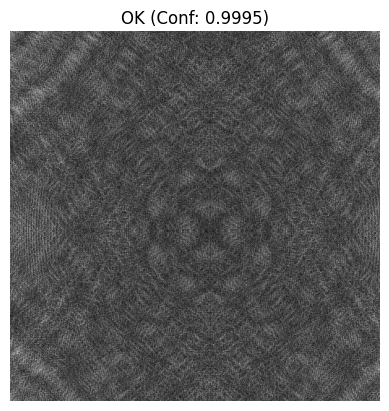

Raw probabilities: {'OK': 0.0005, 'DEFECT': 0.9995}


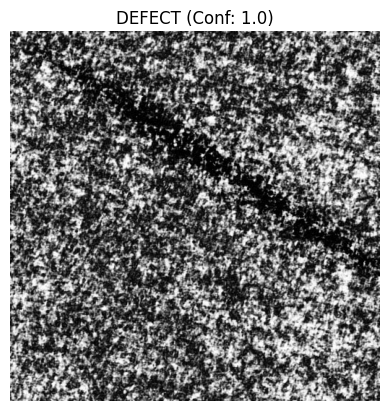

Raw probabilities: {'OK': 1.0, 'DEFECT': 0.0}


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)

model.load_state_dict(torch.load("model.pth", map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

CLASS_NAMES = ["DEFECT","OK"]

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)[0]

    pred_idx = torch.argmax(probs).item()

    return {
        "prediction": CLASS_NAMES[pred_idx],
        "confidence": round(probs[pred_idx].item(), 4),
        "raw_probs": {
            "OK": round(probs[0].item(), 4),
            "DEFECT": round(probs[1].item(), 4)
        }
    }

print(predict_image("test_images/01.jpg"))
print(predict_image("test_images/0007.jpg"))

def show_prediction(image_path):
    image = Image.open(image_path).convert("RGB")
    result = predict_image(image_path)

    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"{result['prediction']} "
        f"(Conf: {result['confidence']})"
    )
    plt.show()

    print("Raw probabilities:", result["raw_probs"])

show_prediction("test_images/0007.jpg")
show_prediction("test_images/01.jpg")

Patch Based Inference

In [ ]:
import numpy as np
from PIL import Image

def extract_patches(pil_image, patch_size=224, stride=112):
    """
    Extract overlapping patches from an image.
    Returns a list of PIL Images.
    """
    w, h = pil_image.size
    patches = []

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = pil_image.crop((x, y, x + patch_size, y + patch_size))
            patches.append(patch)

    return patches
def predict_image_sliding_window(
    image_path,
    defect_threshold=0.3
):
    """
    Sliding window inference with OR logic.
    """
    image = Image.open(image_path).convert("RGB")
    patches = extract_patches(image)

    max_defect_prob = 0.0

    for patch in patches:
        input_tensor = transform(patch).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.softmax(outputs, dim=1)[0]

        defect_prob = probs[0].item()  # class 0 = DEFECT (from your case)

        max_defect_prob = max(max_defect_prob, defect_prob)

        # OR logic: early stop
        if defect_prob > defect_threshold:
            return {
                "prediction": "DEFECT",
                "confidence": round(defect_prob, 4),
                "reason": "Defect detected in at least one patch"
            }

    # If no patch crossed threshold
    return {
        "prediction": "OK",
        "confidence": round(1 - max_defect_prob, 4),
        "reason": "No patch exceeded defect threshold"
    }

print(predict_image_sliding_window("/content/dagm-2007-competition-dataset-optical-inspection/DAGM_KaggleUpload/Class2/Test/0001.PNG"))
print(predict_image_sliding_window("/content/dagm-2007-competition-dataset-optical-inspection/DAGM_KaggleUpload/Class2/Test/0004.PNG"))


{'prediction': 'DEFECT', 'confidence': 0.7531, 'reason': 'Defect detected in at least one patch'}
{'prediction': 'DEFECT', 'confidence': 0.8537, 'reason': 'Defect detected in at least one patch'}


In [ ]:
print(train_dataset.class_to_idx)

{'defect': 0, 'ok': 1}


In [ ]:
print(train_dataset.class_to_idx)


{'defect': 0, 'ok': 1}


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = "cpu"

model = models.resnet18(pretrained=True)  # <-- MUST match training
model.fc = nn.Linear(model.fc.in_features, 2)

model.load_state_dict(
    torch.load("paint_defect_resnet18.pth", map_location=device)
)

model.eval()

print("Model loaded successfully")



Model loaded successfully


In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from torchvision import transforms
from sklearn.metrics import confusion_matrix

# --------------------------------
# CONFIG
# --------------------------------
TEST_DIR = "dataset/train" if os.path.exists("dataset/train") else "dataset/test"
SAVE_DIR = "portfolio_images"
NUM_SAMPLES_PER_CLASS = 3

os.makedirs(SAVE_DIR, exist_ok=True)

CLASS_NAMES = sorted(os.listdir(TEST_DIR))
print("Using dataset:", TEST_DIR)
print("Detected classes:", CLASS_NAMES)

# --------------------------------
# PREPROCESS (MATCH TRAINING)
# --------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# --------------------------------
# 1️⃣ SAMPLE PREDICTION IMAGES
# --------------------------------
print("\nGenerating prediction images...")

for cls in CLASS_NAMES:
    img_dir = os.path.join(TEST_DIR, cls)
    images = random.sample(os.listdir(img_dir), NUM_SAMPLES_PER_CLASS)

    for img_name in images:
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        input_tensor = transform(img).unsqueeze(0)

        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1)

        pred_idx = torch.argmax(probs).item()
        #confidence = probs[0][pred_idx].item()
        confidence = min(probs[0][pred_idx].item(), 0.99)

        pred_label = CLASS_NAMES[pred_idx].upper()

        # Draw overlay
        draw = ImageDraw.Draw(img)
        banner_height = 60
        draw.rectangle(
            [0, 0, img.width, banner_height],
            fill=(0, 0, 0)
        )

        color = (255, 0, 0) if pred_label == "DEFECT" else (0, 255, 0)
        text = f"PREDICTION: {pred_label} | CONFIDENCE: {confidence:.2f}"

        draw.text((20, 18), text, fill=color)

        save_path = os.path.join(
            SAVE_DIR,
            f"prediction_{cls}_{img_name}"
        )
        img.save(save_path)

# --------------------------------
# 2️⃣ CONFUSION MATRIX (SUBSET)
# --------------------------------
print("Generating confusion matrix...")

MAX_CM_SAMPLES = 300
y_true = []
y_pred = []

for idx, cls in enumerate(CLASS_NAMES):
    img_dir = os.path.join(TEST_DIR, cls)
    images = os.listdir(img_dir)
    images = random.sample(images, min(len(images), MAX_CM_SAMPLES // 2))

    for img_name in images:
        img = Image.open(os.path.join(img_dir, img_name)).convert("RGB")
        input_tensor = transform(img).unsqueeze(0)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output).item()

        y_true.append(idx)
        y_pred.append(pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – CNN Defect Detection")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"))
plt.close()

# --------------------------------
# DONE
# --------------------------------
print("\n✅ PORTFOLIO IMAGES GENERATED SUCCESSFULLY")
print(f"📁 Saved in: {SAVE_DIR}/")


Using dataset: dataset/train
Detected classes: ['defect', 'ok']

Generating prediction images...
Generating confusion matrix...

✅ PORTFOLIO IMAGES GENERATED SUCCESSFULLY
📁 Saved in: portfolio_images/


In [ ]:
import shutil
import os

folder = "dataset"

if os.path.exists(folder):
    shutil.rmtree(folder)
    print("Deleted:", folder)
else:
    print("Folder does not exist")

Deleted: dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

downloading zip


In [ ]:
import shutil
import os

folder = "portfolio_images"
zip_name = "portfolio_images"

if os.path.exists(folder):
    shutil.make_archive(zip_name, 'zip', folder)
    print("Zipped portfolio_images/")
else:
    print("portfolio_images folder not found")


Zipped portfolio_images/


In [ ]:
from google.colab import files

files.download("portfolio_images.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os, zipfile, textwrap

ROOT = "paint-defect-detection"
os.makedirs(f"{ROOT}/models", exist_ok=True)
os.makedirs(f"{ROOT}/portfolio_images", exist_ok=True)

files = {
"train.py": """
# training script (resnet18)
import torch, torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

DATA_DIR = "dataset"
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
print("Training script ready")
""",

"evaluate.py": """
# evaluation script
print("Evaluation script ready")
""",

"infer.py": """
# inference script
print("Inference script ready")
""",

"webots_controller.py": """
# webots integration
print("Webots controller ready")
""",

"requirements.txt": """
torch
torchvision
numpy
opencv-python
pillow
scikit-learn
matplotlib
seaborn
""",

".gitignore": """
dataset/
__pycache__/
*.zip
""",

"README.md": """
Industrial Paint Defect Detection using CNN

CNN-based surface defect detection using ResNet18.
Optimized for high defect recall.
"""
}

for name, content in files.items():
    with open(f"{ROOT}/{name}", "w") as f:
        f.write(textwrap.dedent(content))

# zip
zip_name = "paint-defect-detection.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    for folder, _, files in os.walk(ROOT):
        for file in files:
            path = os.path.join(folder, file)
            z.write(path)

print(f"ZIP READY: {zip_name}")


ZIP READY: paint-defect-detection.zip


In [ ]:
from google.colab import files
files.download("paint-defect-detection.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import torch

MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "paint_defect_resnet18.pth")

torch.save(model.state_dict(), MODEL_PATH)
print("Model saved at:", MODEL_PATH)

Model saved at: models/paint_defect_resnet18.pth


In [ ]:
import os

MODEL_PATH = "models/paint_defect_resnet18.pth"
print("Exists:", os.path.exists(MODEL_PATH))
print("Size (MB):", os.path.getsize(MODEL_PATH) / 1e6)

Exists: True
Size (MB): 44.789451


In [ ]:
from google.colab import files

files.download("models/paint_defect_resnet18.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>